## Computing and plotting ENS data (GRIB)

In this notebook we will demonstrate how to:
* compute and plot ENS mean and spread maps
* create a stamp plot
* create a spaghetti plot
* compute and plot ENS probability and percentile maps
* generate a CDF plot for a given location

We will use **Metview** and in the case of the CDF also **numpy** and **matplotlib** to achieve our goals.

### Preparations

In [1]:
import metview as mv

The data we work with in this notebook is related to the **St Jude wind storm** from 2013 October. The windgust and the 850 hPa geopotential forecast were retrieved from **MARS** for a few steps on a low resolution grid to provide input for the exercises. These are stored in files "fc.grib" and "ens.grib". 

Alternatively you can retrieve this data from MARS (since it is not a recent forecast the retrieval can take quite a long time).


In [2]:
use_mars = False

In [3]:
if use_mars:
    params = {
        "fg": {"step": [72, 78, 84], "param": "10fg3", "levtype": "sfc"},
        "z": {"step": [78], "param": "z", "levtype": "pl", "levelist": 850},
    }

    d_common = {
         "date": 20131025,
         "time": 0,
         "grid": [0.75, 0.75],
         "area": [43.5, -19.5, 66, 15.75]
         }
     
    g_fc = mv.Fieldset()
    g_en = mv.Fieldset()
    for v in params.values():
        g_fc.append(mv.retrieve(d_common, v, type="fc"))
        g_en.append(mv.retrieve(d_common, v, stream="enfo", type="cf"))
        g_en.append(mv.retrieve(d_common, v, stream="enfo", type="pf", number=[1,"TO", 50]))
else:
    g_fc = mv.read("fc_storm.grib")
    g_en = mv.read("ens_storm.grib")

### Creating an ENS plot

We will create a 2x2 plot for a given timestep (=78h) of the windgust forecast. The maps in the plot will show the following fields:
* deterministic forecast
* control forecast
* ENS mean
* ENS spread

First we read the **deterministic forecast** and building a title for it:

In [4]:
fc = mv.read(data=g_fc, param="10fg3", step=78)
fc_title = mv.mtext(text_lines=["HRES"], 
                    text_font_size=0.4)

Next we read the **ENS** forecast data (51 fields):

In [5]:
en = mv.read(data=g_en, param="10fg3", step=78)
len(en)

51

and check the **content** using **grib_get** (here "cf" means control forecast, while "pf" means perturbed forecast):

In [6]:
mv.grib_get(en, ['date', 'time', 'type', 'number',
                'shortName', 'step'])[:8]  

[['20131025', '0000', 'cf', '0', '10fg3', '78'],
 ['20131025', '0000', 'pf', '1', '10fg3', '78'],
 ['20131025', '0000', 'pf', '2', '10fg3', '78'],
 ['20131025', '0000', 'pf', '3', '10fg3', '78'],
 ['20131025', '0000', 'pf', '4', '10fg3', '78'],
 ['20131025', '0000', 'pf', '5', '10fg3', '78'],
 ['20131025', '0000', 'pf', '6', '10fg3', '78'],
 ['20131025', '0000', 'pf', '7', '10fg3', '78']]

We continue with reading the **control forecast** and making title for it:

In [7]:
cf = mv.read(data=en, type="cf")
cf_title = mv.mtext(text_lines=["CF"], 
                    text_font_size=0.4)

Then we compute the **ensemble mean** and **spread** and define the titles for them:

In [8]:
e_mean = mv.mean(en)
e_spread = mv.stdev(en)

mean_title = mv.mtext(text_lines=["ENS Mean"], 
                      text_font_size=0.4)
spread_title = mv.mtext(text_lines=["ENS Spread"], 
                        text_font_size=0.4)

We need two **contouring definitions** for the plots: one for the windgust itself and another one for the ensemble spread:

In [9]:
wgust_shade = mv.mcont(
    legend                       = "on",
    contour_line_colour          = "navy",
    contour_highlight            = "off",
    contour_level_selection_type = "level_list",
    contour_level_list           = [15,20,25,30,35,40,50],
    contour_label                = "off",
    contour_shade                = "on",
    contour_shade_colour_method  = "list",
    contour_shade_method         = "area_fill",
    contour_shade_colour_list    = ["sky","greenish_blue","avocado",
                                    "orange","orangish_red","violet"]
    )

spread_shade = mv.mcont(
    legend                       = "on",
    contour_line_colour          = "navy",
    contour_highlight            = "off",
    contour_level_selection_type = "level_list",
    contour_level_list           = [2,3,4,5,6,7,8,9,10],
    contour_label                = "off",
    contour_shade                = "on",
    contour_shade_colour_method  = "palette",
    contour_shade_method         = "area_fill",
    contour_shade_palette_name   = "m_purple_9"
    )

legend = mv.mlegend(legend_text_font_size = 0.35)

Next we define the **map view** and its **style**:

In [10]:
coast = mv.mcoast(
    map_coastline_land_shade        = "on",
    map_coastline_land_shade_colour = "grey",
    map_coastline_sea_shade         = "on",
    map_coastline_sea_shade_colour  = "RGB(0.8944,0.9086,0.933)",
    map_coastline_thickness         =  2,
    map_boundaries                  = "on",
    map_boundaries_colour           = "charcoal",
    map_grid_colour                 = "charcoal",
    map_grid_longitude_increment    = 10
    )

view = mv.geoview(
    map_area_definition = 'corners',
    area = [45,-15,65,15],
    coastlines = coast
    )

Finally we define the **plot layout**, set the plotting target to the **Jupyter notebook** (we only have to do it once in a notebook) and generate the plot:

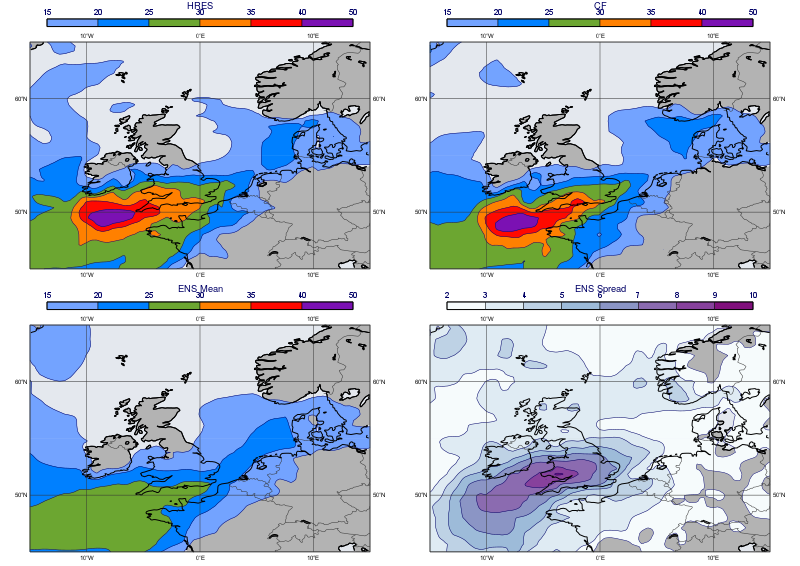

In [11]:
dw = mv.plot_superpage(pages = mv.mvl_regular_layout(view,2,2,1,1))

mv.setoutput('jupyter')

mv.plot(dw[0], fc, wgust_shade, fc_title, legend, 
        dw[1], cf, wgust_shade, cf_title, legend,
        dw[2], e_mean, wgust_shade, mean_title, legend,
        dw[3], e_spread, spread_shade, spread_title, legend)

### Creating a stamp plot

In a **stamp plot** we plot all the ensemble members into the different map within the same plot. It provides us with a quick overview on how the forecast members differ from each other.

The maps in a stamp plot will tiny so first we need to **adapt the contour and map settings** to this small size:

In [12]:
wgust_shade_stamp = mv.mcont(
    wgust_shade,
    legend="off"
    )

coast_stamp = mv.mcoast(
    coast,
    map_label="off",
    map_grid_colour= "RGB(0.6, 0.6, 0.6)"
    )

view_stamp = mv.geoview(
    view,
    coastlines = coast_stamp,
    subpage_y_position = 17,
    subpage_y_lenght = 80
    )

Next we build a large enough layout catering for all the 51 members. We define a plot layout with **7 rows** and **8 columns**:

In [13]:
dw = mv.plot_superpage(pages = mv.mvl_regular_layout(view_stamp,8,7,1,1, [5,100,0,100]))

Finally we generate the plot. In order to manage the great number of arguments we need for the **plot()** command (over 200) we use a **list** to build the plot contents. 

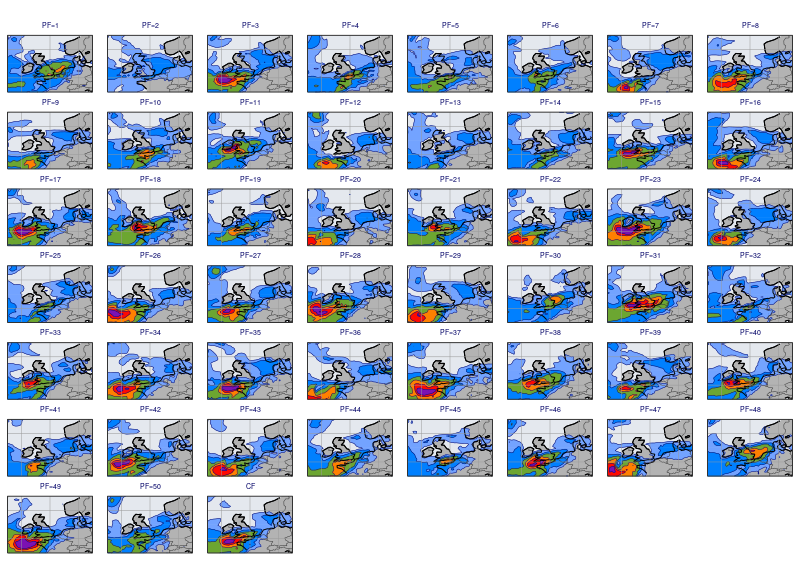

In [14]:
pl_lst = []

# perturbed forecats
for i in range(1, 51):
    f = mv.read(data=en, type="pf", number=i)
    title = mv.mtext(text_lines=["PF=" + str(i)], text_font_size=0.3)
    pl_lst.append([dw[i-1], f, wgust_shade_stamp, title])

# control forecats
f = mv.read(data=en, type="cf")
title = mv.mtext(text_lines=["CF"], text_font_size=0.3)
pl_lst.append([dw[50], f, wgust_shade_stamp, title])    
    
mv.plot(pl_lst)    

### Creating a spaghetti plot

In a **spaghetti plot** we select an isoline value and plot that isoline into the same map from all the ensemble members. We will use the 125 dkm isoline of the **850 hPa geopotential** forecast since it is a good indicator of the position of the trough associated with the St Jude storm. 

First we read the data and define the isolines: we will highlight the deterministic and control forecasts with a different line colour and width.

In [15]:
z_en = mv.read(data=g_en, param="z", levelist=850, step=78)

cont_pf = mv.mcont(
    contour_label="off",
    contour_level_selection_type="level_list",
    contour_level_list=125,
    contour_line_colour="blue",
    contour_highlight="off",
    grib_scaling_of_derived_fields="on"
 )

cont_cf = mv.mcont(
    cont_pf,
    contour_line_colour="red",
    contour_line_thickness=3
)


cont_fc = mv.mcont(
    cont_pf,
    contour_line_colour="orange",
    contour_line_thickness=3
)

Then we use the same technique to build the plot contents as for the stamp plot. The **title** requires a special treatment: the implementation below is used to avoid having 52 titles (one for each ENS member + the deterministic forecast) in the plot.

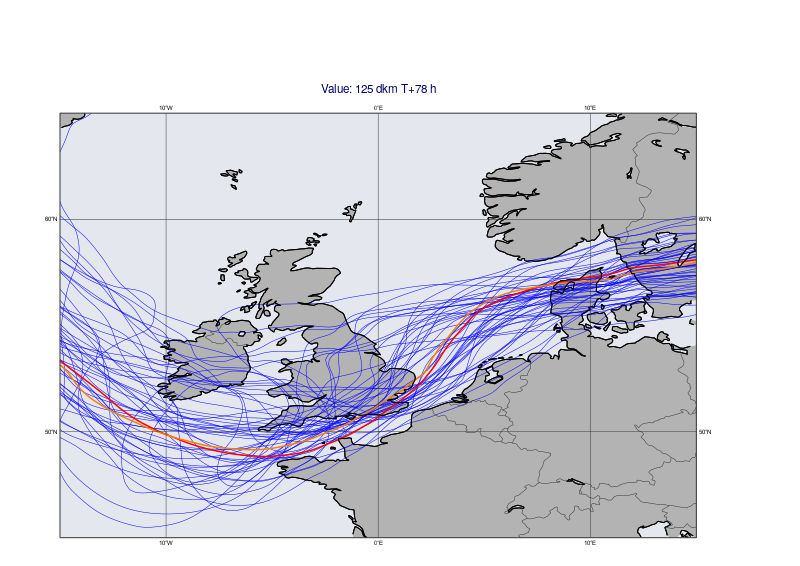

In [16]:
pf = []

# perturbed forecats
for i in range(1,51):
    f = mv.read(data=z_en, type="pf", number=i)
    pf.append(f)

# control forecats
cf = mv.read(data=z_en, type="cf") 
 
# deterministic forecats
fc = mv.read(source="fc_storm.grib", param="z", level=850, step=78)     
    
title=mv.mtext(text_line_1="Value: 125 dkm T+<grib_info key='step' where='number=50' /> h", 
               text_font_size=0.5 )

mv.plot(view, pf, cont_pf, 
        cf, cont_cf, 
        fc, cont_fc, title)

### Generating a probability map

We could see in the stamp plot that quite a few ENS members predicted gale force wind close to the English Channel. We will now compute the probability of having a wind gust > 28 m/s (~100 km/h) for the given timestep. The computation itself is really simple. The first line below performs a masking turning all the grid point values into 0 or 1 according to the specified condition. Then the just take the mean to get the probabilities and scale the values into percentages:

In [17]:
prob = en > 28
prob = mv.mean(prob) * 100

Next we plot the probability field with a custom contour shading and title into the same map that we used above.

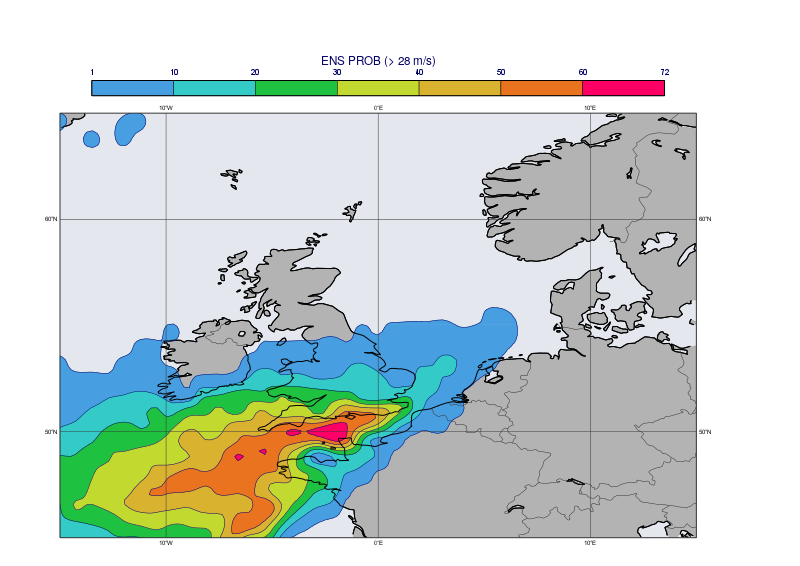

In [18]:
prob_shade = mv.mcont(
    legend                       = "on",
    contour_line_colour          = "navy",
    contour_highlight            = "off",
    contour_level_selection_type = "level_list",
    contour_level_list           = [1, 10, 20, 30, 40, 50, 60, 72],
    contour_label                = "off",
    contour_shade                = "on",
    contour_shade_colour_method  = "palette",
    contour_shade_method         = "area_fill",
    contour_shade_palette_name   = "eccharts_rainbow_blue_red_7"
    )

prob_title = mv.mtext(text_lines=["ENS PROB (> 28 m/s)"], 
                      text_font_size=0.5)

mv.plot(view, prob, prob_shade, legend, prob_title)

### Generating a percentile map

Another way of looking at the probabilities is to use a percentile map which give us a more detailed view about the actual distribution of the ENS forecast values. In this example we will generate the percentile map for 80%. The value in each gridpoint will be the windgust value below which 80% of the ENS members fall.

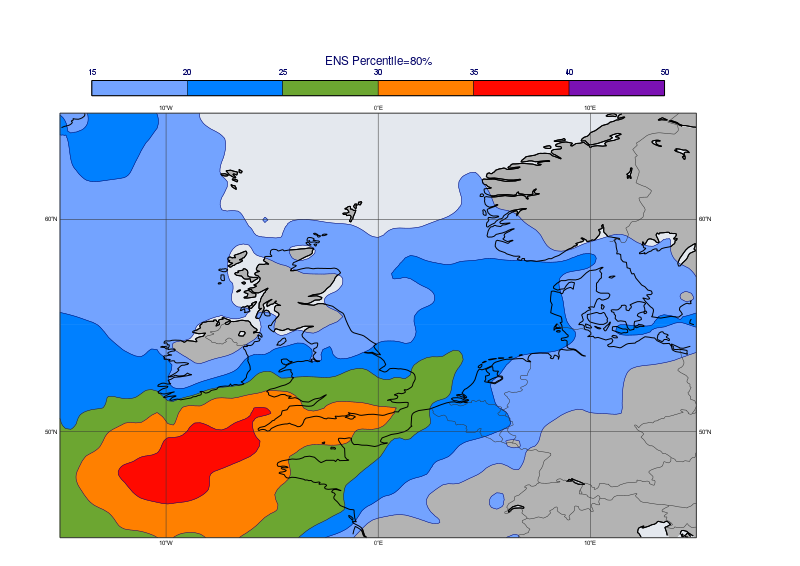

In [19]:
perc = mv.percentile(data=en, percentiles=80)

perc_title = mv.mtext(text_lines=["ENS Percentile=80%"], 
                      text_font_size=0.5)

mv.plot(view, perc, wgust_shade, legend, perc_title)

### Creating a CDF plot

CDF (**Cumulative Distribution Function**) curves can be used to study the forecast probabilities at a given location in detail. The CDF curve constructed form ENS data tells us the probability that the forecast will be less than or equal to a given value.

In this example we will build a CDF plot for the location of Reading for 3 consecutive time steps (72, 78 and 84 h). We use Metview's **nearest_gridpoint()** function tho extract the ENS values at the target location into a **numpy** array. Then the CDF is computed by numpy and for simpllicity the line chart is generated with **matplotlib**.

In [20]:
import numpy as np
import matplotlib.pyplot as plt

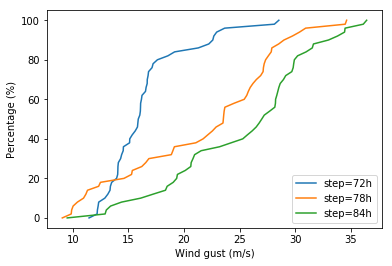

In [21]:
pos = [51.5, -1]
lines = []
for step in [72, 78, 84]:
    f = mv.read(data=g_en, param="10fg3", step=step)
    x = mv.nearest_gridpoint(f, pos)
    
    # form cdf
    y = np.arange(0, 101)
    x = np.percentile(x, y)    
    
    # make line plot object
    line, = plt.plot(x, y, label="step={}h".format(step))
    lines.append(line)

plt.legend(handles=lines, loc='lower right')
plt.xlabel('Wind gust (m/s)')
plt.ylabel('Percentage (%)')
plt.show()

# Additional resources

- [Introductory Metview training course](https://confluence.ecmwf.int/display/METV/Data+analysis+and+visualisation+using+Metview)
- [Metview's Python interface](https://confluence.ecmwf.int/display/METV/Metview%27s+Python+Interface)
- [Function list](https://confluence.ecmwf.int/display/METV/List+of+Operators+and+Functions)